<a href="https://colab.research.google.com/github/SerhiiAndreiko/HW_DATA_04/blob/main/HW_04_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [48]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [49]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [50]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bikes_rent.csv")
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

In [51]:
list(df.head())

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed(mph)',
 'windspeed(ms)',
 'cnt']

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          731 non-null    int64  
 1   yr              731 non-null    int64  
 2   mnth            731 non-null    int64  
 3   holiday         731 non-null    int64  
 4   weekday         731 non-null    int64  
 5   workingday      731 non-null    int64  
 6   weathersit      731 non-null    int64  
 7   temp            731 non-null    float64
 8   atemp           731 non-null    float64
 9   hum             731 non-null    float64
 10  windspeed(mph)  731 non-null    float64
 11  windspeed(ms)   731 non-null    float64
 12  cnt             731 non-null    int64  
dtypes: float64(5), int64(8)
memory usage: 74.4 KB


Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

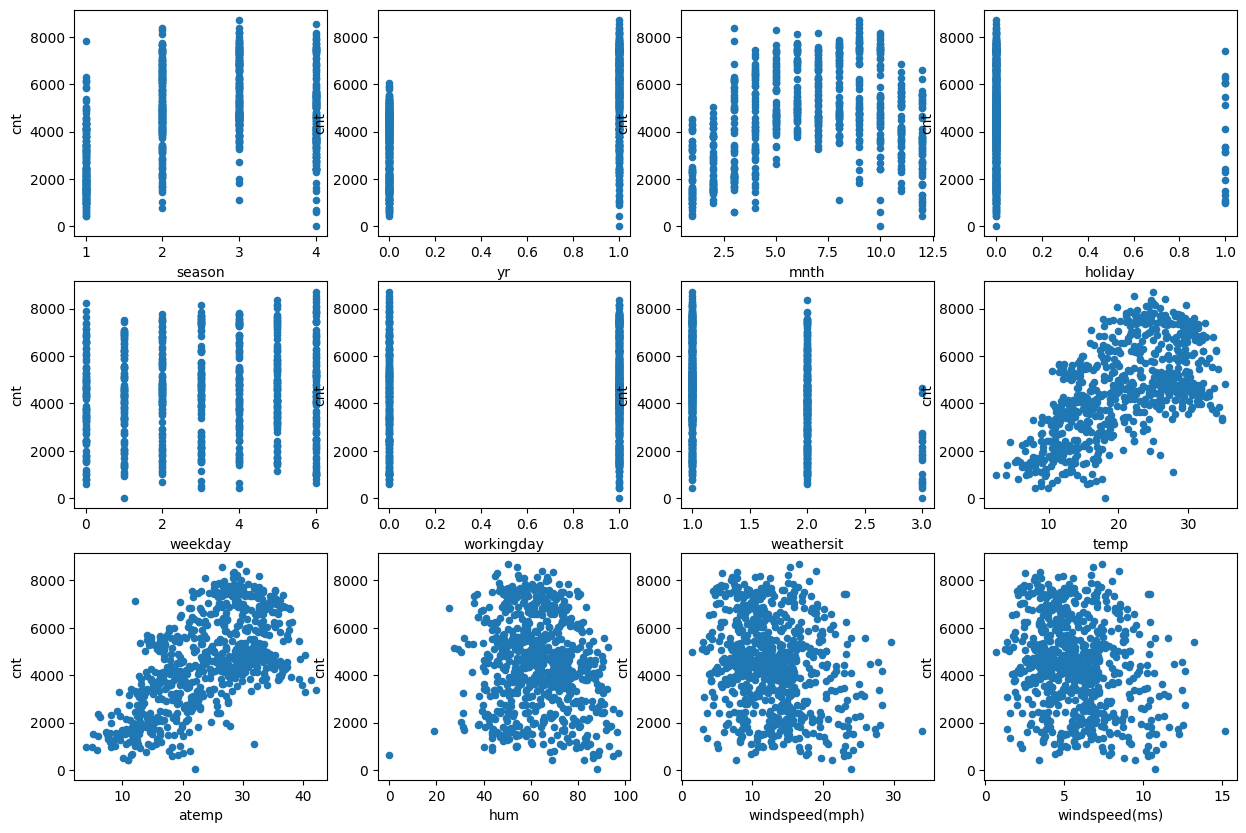

In [53]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

plt.show()


__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?

1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.
***Відповідь***
   Синосуідальна залежність.Очікувано, що влітку, коли температура(temp) вища та більше годин світлодіодного освітлення, попит на прокат велосипедів буде більшим, ніж взимку, коли температура нижча та менше годин денного світла.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [54]:
correlations = df.iloc[:, :-1].corrwith(df['cnt']).round(2)
correlations


season            0.41
yr                0.57
mnth              0.28
holiday          -0.07
weekday           0.07
workingday        0.06
weathersit       -0.30
temp              0.63
atemp             0.63
hum              -0.10
windspeed(mph)   -0.23
windspeed(ms)    -0.23
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [55]:
correlation_results=df[['temp','atemp','hum','windspeed(mph)','windspeed(ms)','cnt']].corr()
correlation_results

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [56]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [57]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [58]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [59]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [60]:
regressor = LinearRegression()
regressor

LinearRegression()

In [61]:

regressor.fit(X, y)
regressor.intercept_

4504.354528214392

In [62]:

# Виведення ваг моделі
print("Weights of the linear regression model:")
for feature, weight in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {weight}")


Weights of the linear regression model:
season: 570.8637960129914
yr: 1021.9653779400622
mnth: -141.3017451148728
holiday: -86.7593446245368
weekday: 137.22506441350538
workingday: 56.391881775973005
weathersit: -330.2264620440312
temp: 367.48373260182126
atemp: 585.5493861188597
hum: -145.61430569885857
windspeed(mph): 12457138390688.885
windspeed(ms): -12457138390887.346


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [63]:
from sklearn.linear_model import Lasso, Ridge

# Створення об'єкта Lasso регресора
lasso_regressor = Lasso()

# Навчання Lasso моделі на всіх даних
lasso_regressor.fit(X, y)

# Виведення ваг Lasso моделі
print("Weights of the Lasso regression model:")
for feature, weight in zip(df.columns[:-1], lasso_regressor.coef_.round(9)):
    print(f"{feature}: {weight}")

Weights of the Lasso regression model:
season: 560.241616031
yr: 1019.463494066
mnth: -128.730627037
holiday: -86.152781334
weekday: 137.347893905
workingday: 55.212370641
weathersit: -332.369856962
temp: 376.36323621
atemp: 576.530793505
hum: -144.129155003
windspeed(mph): -197.139689402
windspeed(ms): -2.8e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [64]:
from sklearn.linear_model import Ridge

# Створення об'єкта Ridge регресора
ridge_regressor = Ridge()

# Навчання Ridge моделі на всіх даних
ridge_regressor.fit(X, y)

# Виведення ваг Ridge моделі
print("Weights of the Ridge regression model:")
for feature, weight in zip(df.columns[:-1], ridge_regressor.coef_):
    print(f"{feature}: {weight}")
print('Зсув:', ridge_regressor.intercept_)


Weights of the Ridge regression model:
season: 563.0645722520181
yr: 1018.9483787875305
mnth: -131.87332028247715
holiday: -86.74609799709232
weekday: 138.00511117871918
workingday: 55.90311037506467
weathersit: -332.34978849907367
temp: 386.45788919190807
atemp: 566.3470470600669
hum: -145.07132729867195
windspeed(mph): -99.25944108179067
windspeed(ms): -99.25944115434177
Зсув: 4504.3488372093025


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [65]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    # Навчання моделей Lasso та Ridge з поточним значенням alpha
    lasso_model = Lasso(alpha=alpha)
    ridge_model = Ridge(alpha=alpha)

    lasso_model.fit(X, y)
    ridge_model.fit(X, y)

    # Запис ваг кожної моделі у відповідні списки
    coefs_lasso.append(lasso_model.coef_)
    coefs_ridge.append(ridge_model.coef_)

# Конвертування списків у np.array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

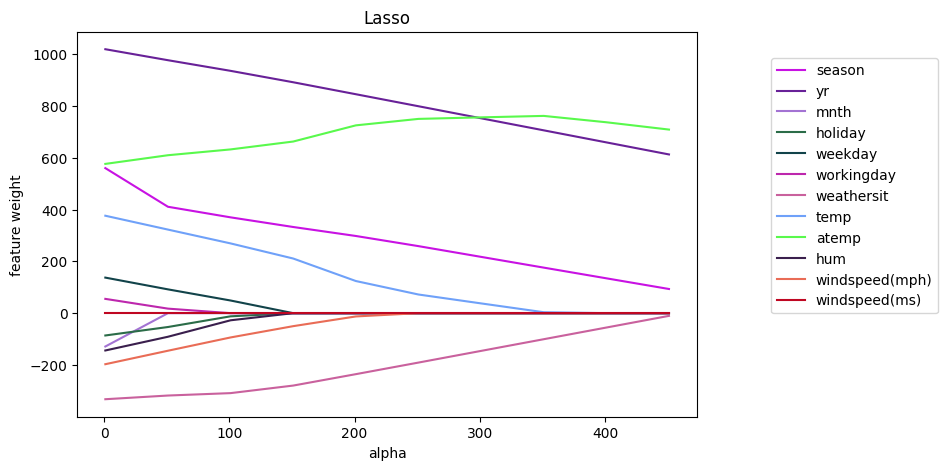

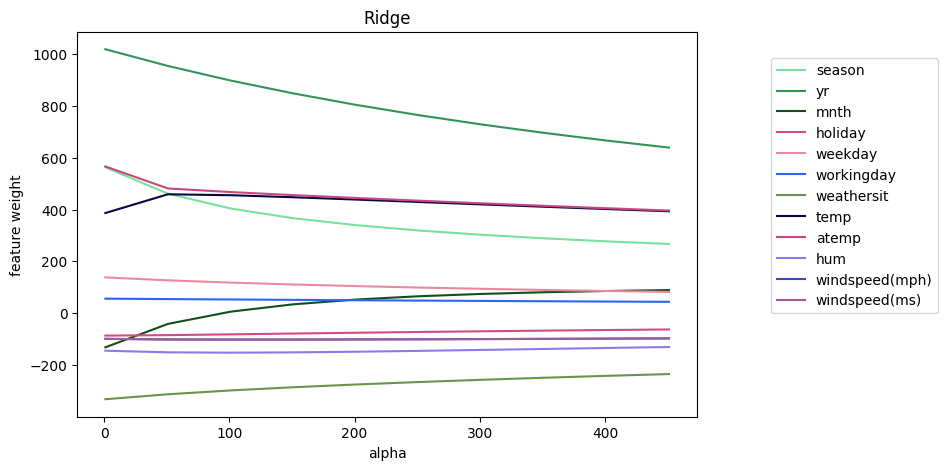

In [66]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
**Відповідь**: Регуляризатор Lasso агресивніше зменшує ваги при одному й тому самому alpha порівняно з регуляризатором Ridge.

2. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
**Відповідь**: Якщо alpha зробити дуже великим, то всі ваги крім зсуву будуть нульовими.
3. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
**Відповідь**: Так, Lasso може виключати одну з ознак windspeed при будь-якому значенні alpha > 0, а Ridge регуляризація це може зробити тільки в тому випадку, якщо коефіцієнт при цій ознаці стає дуже малим, але не точно нуль.
4. Який із регуляризаторів підійде для відбору неінформативних ознак?

**Відповідь**: Lasso регуляризація підходить для відбору неінформативних ознак, оскільки вона має здатність автоматично виключати ознаки, які мають малий вплив на модель.







### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [84]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()



Alpha = 6


season: 532.0189828413535
yr: 1015.0602226430595
mnth: -100.03952614356629
holiday: -83.29395987529904
weekday: 132.50446549095795
workingday: 51.557085614073735
weathersit: -330.5598567399817
temp: 370.67985503003405
atemp: 581.396931065498
hum: -140.00740550068844
windspeed(mph): -191.77140847135036
windspeed(ms): -2.6854702314758792e-08




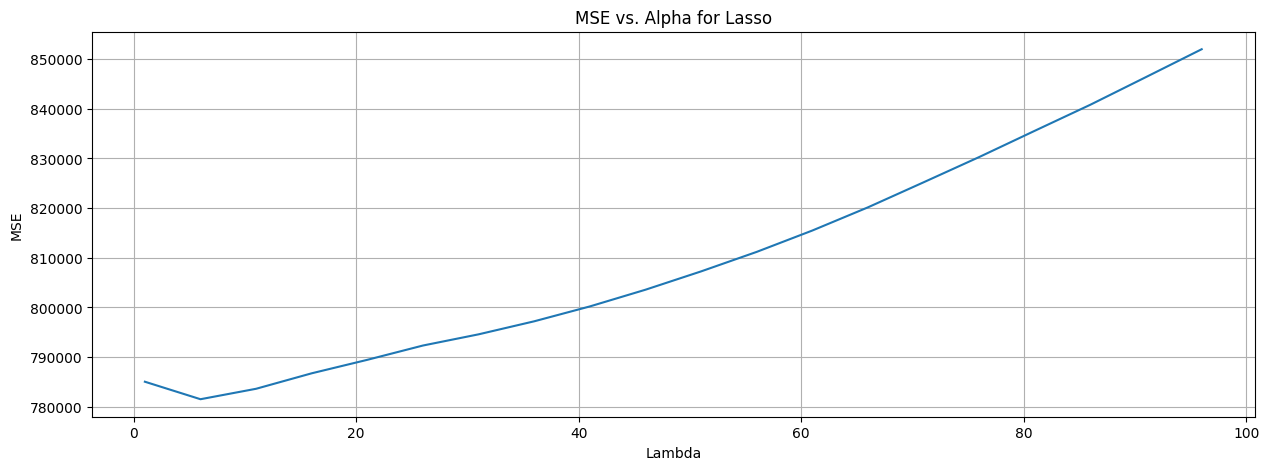

In [85]:
from sklearn.linear_model import LassoCV

alphas_cv = np.arange(1, 100, 5)
model_cv = LassoCV(alphas=alphas_cv, cv=3)
model_cv.fit(X, y)

title = "MSE vs. Alpha for Lasso"
data = list(zip(model_cv.alphas_, np.mean(model_cv.mse_path_, axis=1)))
print('\nAlpha = ' + str(model_cv.alpha_))
print('\n')
for item in zip(df_shuffled.columns[:-1], model_cv.coef_):
  print (f'{item[0]}: {item[1]}')
print('\n')
create_plot(data, title, xlabel='Lambda', ylabel='MSE')

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


In [87]:
model_cv.mse_path_.shape


(20, 3)

Мінімальне MSE: 733725.7604052249
Alpha: 6
Мінімальне MSE: 799433.1673691692
Alpha: 1
Мінімальне MSE: 796979.8955193626
Alpha: 51


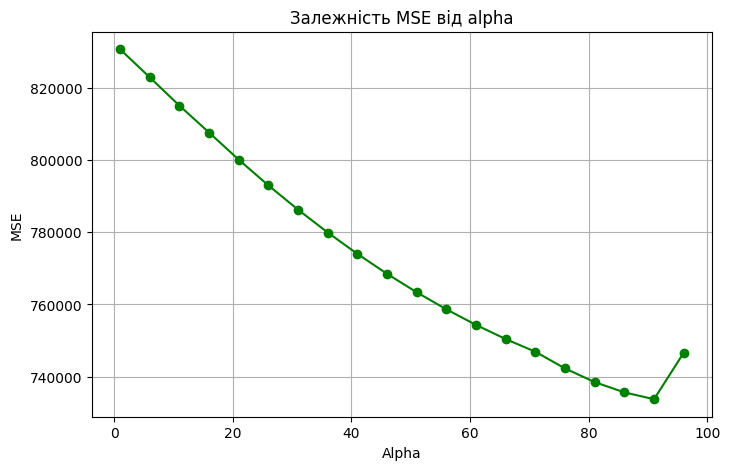

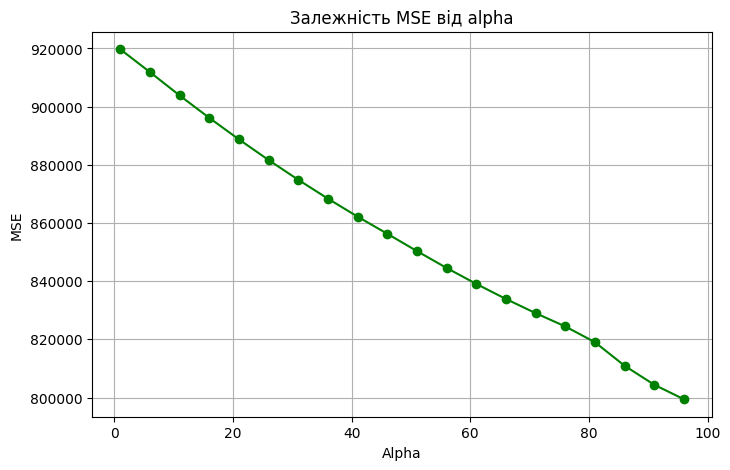

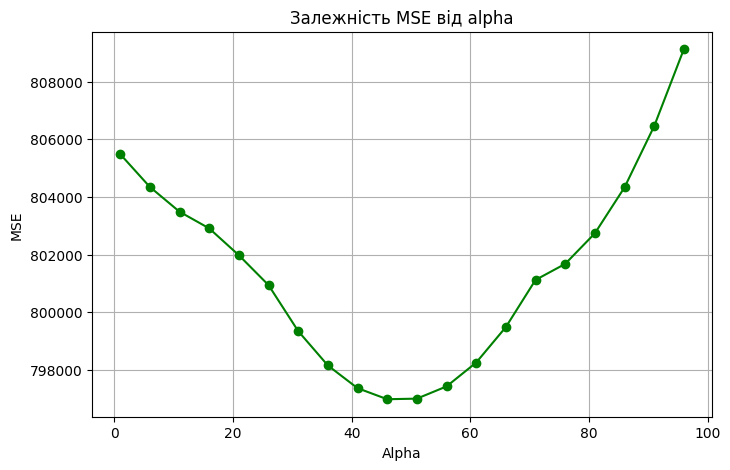

In [91]:
def alpha_index(model_cv, index):
    plt.figure(figsize=(8, 5))
    indexes = np.argsort(model_cv.alphas_)
    mse_mean = model_cv.mse_path_[:, index]
    x = model_cv.alphas_
    y = mse_mean[indexes]

    plt.plot(x, y, marker='o', linestyle='-', color='g')
    plt.grid(1)
    plt.title('Залежність MSE від alpha')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')

    min_mse = np.min(mse_mean)
    min_alpha = model_cv.alphas_[np.argmin(mse_mean)]
    print('Мінімальне MSE:', min_mse)
    print('Alpha:', min_alpha)

for i in range(3):
    alpha_index(model_cv, i)




На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [92]:

coefficients = dict(zip(df.columns[:-1], model_cv.coef_))

sorted_coefficients = sorted(coefficients.items(), key=lambda x: x[1], reverse=True)

top_features = sorted_coefficients[:4]
print("4 ознаки з найбільшими позитивними коефіцієнтами:")
for feature, coefficient in top_features:
    print(f"{feature}: {coefficient}")


4 ознаки з найбільшими позитивними коефіцієнтами:
yr: 1015.0602226430595
atemp: 581.396931065498
season: 532.0189828413535
temp: 370.67985503003405


Можна логічно припустити, що зі зростанням значень цих ознак збільшується попит на прокат велосипедів.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [95]:
for weight, name in sorted_coefficients[-3:]:
  print('%s - %s' % (name, weight))

-140.00740550068844 - hum
-191.77140847135036 - windspeed(mph)
-330.5598567399817 - weathersit


Ці ознаки мають величини коефіцієнтів, що негативно впливають на кількість прокатів велосипедів. Наприклад, високий рівень вологості, поганий стан погоди та висока швидкість вітру можуть зменшити бажання людей користуватися велосипедами.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [96]:
close_to_zero_features = [(feature, coefficient) for feature, coefficient in coefficients.items() if abs(coefficient) < 1e-3]

print("Ознаки з коефіцієнтами, близькими до нуля (< 1e-3):")
for feature, coefficient in close_to_zero_features:
    print(f"{feature}: {coefficient}")


Ознаки з коефіцієнтами, близькими до нуля (< 1e-3):
windspeed(ms): -2.6854702314758792e-08


Враховуючи дуже малий вплив цієї ознаки на прогнози моделі, можна припустити, що швидкість вітру у метрах на секунду не є вирішальним чинником для попиту на велосипеди в даному наборі даних. Це відбувається тому що кореляція відносно мала, та цей коеф. лінійно залежний та існує лінійна залежність.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.